<a href="https://colab.research.google.com/github/abhirajD/email_purchase_prediction/blob/main/Main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix


In [215]:
df = pd.read_csv('./drive/MyDrive/Q3_2021_applications/6sense challange/training.tsv', delimiter='\t', names=['user_id', 'activity_date', 'activity_type'])
df['activity_date'] = pd.to_datetime(df['activity_date'])
df.head()

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


# Problem Discussion

What we know:
1. Each user has some activity on email and web. Email open, click through, form submit, web view and even customer support.
2. Occourance of `Purchase` event is our target.
3. Because its web related activity, time frame of all activities might not go beyond a couple of days.
4. Some events have high correlation/causation with the purchase event. Ex: May be someone who reaches out to customer support most probably buys.


Plan:
1. `[Iteration A.]` We dont know if time is important. May be occourance of events is enough. If this is true, we can encode event counts in a matrix.
Gaussian Naive Bayes OR decision tree might be a straight forward approach to fit this kind of data. 

2. `[Iteration B.]` If sequence/time has an impact. Ex: how closely events happen and when they happen. We might have to engineer some features like:
  * Delta time between two events.
  * Occourance of sequencing of events. Similar to n-grams.
  * Length of session.
If 1st approach doesnt give a decent fit, we can still use the features generated there. I am trying to follow an iterative (MVP) approach so that we have control over effort, time and complexity.

# EDA

Pre-processing and hypothesis testing.

I'll maintain a list of all the hypothesis here as I continue my EDA:
1. `[Simplifying hypothesis]` Each user has 1 purchase:

    False: A user can have as many as 350 purchases.
2. `[Simplifying hypothesis]`User has sessions not lasting more than a couple of days:
    
    False. Session lengths cab be as long as 700 days.
3. `[Simplifying hypothesis]`User has no more than 1 session (two sets of activities far apart in time):

    False. A user can have multiple sessions

In [66]:
## Viewing activity of one user
df[df.user_id == '00002acbe042d69']

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen
5,00002acbe042d69,2013-07-25,EmailOpen
6,00002acbe042d69,2013-07-26,EmailOpen
7,00002acbe042d69,2013-08-01,EmailOpen
8,00002acbe042d69,2013-08-05,EmailOpen
9,00002acbe042d69,2013-08-12,EmailOpen


In [67]:
## Average perchase per user
def purchase_count(df):
  return len(df[df.activity_type == 'Purchase'])

purchase_per_user_df = df.groupby('user_id').apply(purchase_count).reset_index()
purchase_per_user_df.columns = ['user_id', 'purchases']

In [68]:
purchase_per_user_df = df.copy()
purchase_per_user_df.loc[purchase_per_user_df.activity_type !='Purchase', 'activity_type'] = 0
purchase_per_user_df.loc[purchase_per_user_df.activity_type =='Purchase', 'activity_type'] = 1

purchase_per_user_df = purchase_per_user_df.groupby('user_id').sum().reset_index()
purchase_per_user_df.columns = ['user_id', 'purchases']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


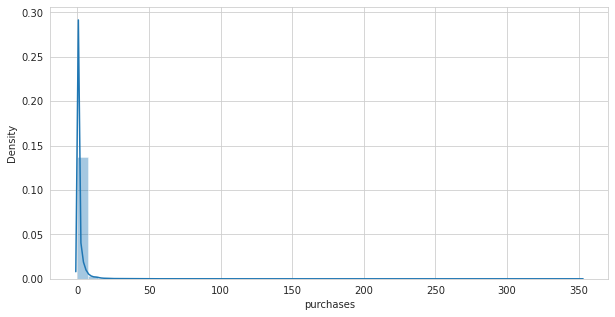

In [69]:
sns.set_style('whitegrid')
plt.figure(figsize = [10,5])
sns.distplot(purchase_per_user_df['purchases'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


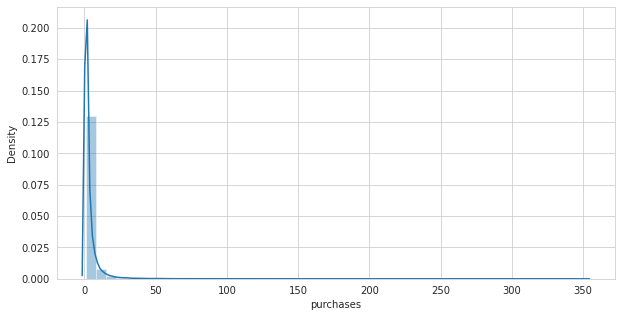

In [70]:
sns.set_style('whitegrid')
plt.figure(figsize = [10,5])
sns.distplot(purchase_per_user_df[purchase_per_user_df.purchases >0]['purchases'])
plt.show()

People can buy multiple stuff.

However, purchase count of 0, 1 and 2 are the most common.



**Thus we'll have to split purchases into sessions per user**

***ASSUMPTION*** Extremely long session (beyond 2sd outside of mean session time) will involve multiple purchases

In [71]:
## Label sessions
df.loc[:, 'purchase_flag'] = 0
df.loc[df.activity_type == 'Purchase', 'purchase_flag'] = 1
df['purchase_flag'] = df['purchase_flag'].shift(1); df['purchase_flag'] = df['purchase_flag'].fillna(0); 
df['session_id'] = np.cumsum(df['purchase_flag'])
display(df.head())
display(df.tail())

,user_id,activity_date,activity_type,purchase_flag,session_id
0,00002acbe042d69,2013-07-11,EmailOpen,0.0,0.0
1,00002acbe042d69,2013-07-11,FormSubmit,0.0,0.0
2,00002acbe042d69,2013-07-15,EmailOpen,0.0,0.0
3,00002acbe042d69,2013-07-17,EmailOpen,0.0,0.0
4,00002acbe042d69,2013-07-18,EmailOpen,0.0,0.0


,user_id,activity_date,activity_type,purchase_flag,session_id
4918672,fffff031760c3f5,2014-06-24,EmailOpen,0.0,395031.0
4918673,fffff031760c3f5,2014-06-25,EmailOpen,0.0,395031.0
4918674,fffff031760c3f5,2014-07-02,EmailOpen,0.0,395031.0
4918675,fffff031760c3f5,2014-08-11,EmailOpen,0.0,395031.0
4918676,fffff031760c3f5,2014-08-21,EmailOpen,0.0,395031.0


In [72]:
## Testing out session length
def session_length(df):
  time_delta = df.activity_date.max() - df.activity_date.min()
  return time_delta.days

session_length_df = df.groupby(['user_id', 'session_id']).apply(session_length).reset_index()
session_length_df.columns = ['user_id', 'session_id', 'session_length']

In [73]:
session_length_df = session_length_df.merge(df[['user_id', 'session_id', 'purchase_flag']], on=['user_id', 'session_id'], how='left')
session_length_df.sample(10)

,user_id,session_id,session_length,purchase_flag
3202238,982e95e4000a39d,255356.0,349,0.0
3126440,93fcb6477f0b5f4,249449.0,631,0.0
2451460,6fa7527a0196850,195866.0,2,1.0
2814325,82cce7deaceb483,225320.0,42,0.0
444321,11d7f0bce6c6e51,35888.0,144,0.0
294136,0b97301d932d75e,23995.0,287,0.0
3699652,b43af3b045ad1fb,295884.0,160,0.0
552001,16a12dff5d52880,44503.0,84,0.0
2157280,60d081cc1e1cfd8,172702.0,172,0.0
1206177,33c78c6cff8c896,97071.0,668,0.0


<Figure size 720x360 with 0 Axes>

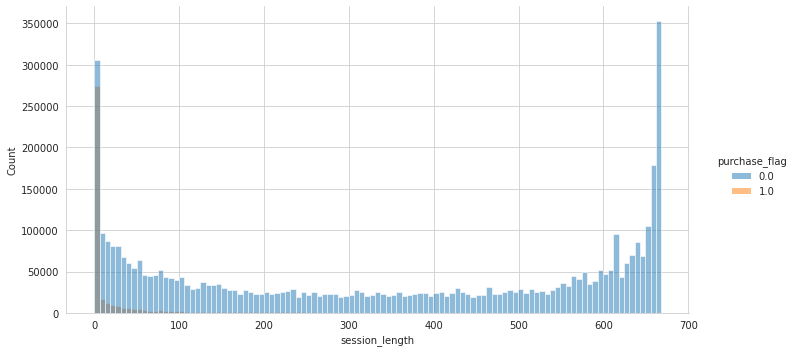

In [74]:
sns.set_style('whitegrid')
plt.figure(figsize = [10,5])
sns.displot(data = session_length_df, x = 'session_length', hue = 'purchase_flag',height=5, aspect=10/5)
plt.show()

In [75]:
## Investigating session with longer session time
long_session_user = session_length_df[session_length_df.session_length == session_length_df.session_length.max()].iloc[0].user_id

df[df.user_id == long_session_user]

,user_id,activity_date,activity_type,purchase_flag,session_id
442,000954284fb33ac,2013-07-01,EmailOpen,0.0,72.0
443,000954284fb33ac,2013-07-03,EmailOpen,0.0,72.0
444,000954284fb33ac,2013-08-23,EmailOpen,0.0,72.0
445,000954284fb33ac,2013-08-26,EmailOpen,0.0,72.0
446,000954284fb33ac,2013-09-25,EmailOpen,0.0,72.0
447,000954284fb33ac,2013-10-24,EmailOpen,0.0,72.0
448,000954284fb33ac,2014-02-03,EmailOpen,0.0,72.0
449,000954284fb33ac,2014-02-24,EmailOpen,0.0,72.0
450,000954284fb33ac,2014-02-25,EmailOpen,0.0,72.0
451,000954284fb33ac,2014-04-03,EmailOpen,0.0,72.0


In [76]:
## Investigating session with longer session time and a purchase
# long_session_user = session_length_df[session_length_df.session_length == session_length_df.session_length.max()].iloc[0].user_id

df[df.user_id == '0000ecf58c94668']

,user_id,activity_date,activity_type,purchase_flag,session_id
30,0000ecf58c94668,2013-10-30,Purchase,0.0,0.0
31,0000ecf58c94668,2013-11-08,Purchase,1.0,1.0
32,0000ecf58c94668,2013-12-06,Purchase,1.0,2.0
33,0000ecf58c94668,2014-02-24,EmailClickthrough,1.0,3.0
34,0000ecf58c94668,2014-02-24,FormSubmit,0.0,3.0
35,0000ecf58c94668,2014-03-04,EmailOpen,0.0,3.0
36,0000ecf58c94668,2014-04-16,Purchase,0.0,3.0
37,0000ecf58c94668,2014-05-15,Purchase,1.0,4.0
38,0000ecf58c94668,2014-06-21,EmailOpen,1.0,5.0
39,0000ecf58c94668,2014-07-01,EmailOpen,0.0,5.0



We can see from the above distribution that no purchase is made beyond a session length of ~200 days. 

We can clearly see that some session last long but its due to not splitting on time vs splitting on purchase event.

We can proceed with feature engineering.



# Feature engineering

Features would be generated per user.
1. `activity_type`: value_count and melt
2. `activity_type` and `activity_date`: Bigrams of sequence with weighted delay. I.E if two activities happen back to back in the same day we count it as 1. Elif, they happen 2 day apart, we count them as 1/2. 

\\[ Score = \frac{1}{T+1} \\]
\\[ T = Timedelta \\]

2. `activity_type` and `activity_date`: Exponentially penalized version of the above. I.E the closer two events are, closer to 1 score.

\\[ Score = \frac{1}{e^T+1} \\]

In [129]:
# Feature 1: Type A: With session splits
df_dummy = pd.get_dummies(df, columns = ['activity_type'])
df_dummy = df_dummy.groupby(['user_id']).sum().reset_index()

#Flag purchase events for users
df_dummy['purchase_flag'] = 0
df_dummy.loc[df_dummy.activity_type_Purchase > 0, 'purchase_flag'] = 1

df_dummy.head().T

,0,1,2,3,4
user_id,00002acbe042d69,0000a3a34bd07e6,0000ecf58c94668,00012205dd4613b,000198d39a568cf
purchase_flag,0,0,1,0,1
session_id,0,0,88,12,13
activity_type_CustomerSupport,0,0,1,0,1
activity_type_EmailClickthrough,0,0,1,0,0
activity_type_EmailOpen,9,20,11,2,0
activity_type_FormSubmit,1,0,1,0,0
activity_type_PageView,0,0,0,0,0
activity_type_Purchase,0,0,6,0,1
activity_type_WebVisit,0,0,0,0,0


In [108]:
# Feature 2: Sequence
def bigram(df):
  df['activity_pair'] = df['activity_type']+'_'+df['activity_type'].shift(-1).fillna('NONE')
  df['time_gap'] = (df['activity_date'].shift(-1) - df['activity_date']).dt.days
  return df

df_seq_dummy = df.groupby(['user_id']).apply(bigram).reset_index()
df_seq_dummy['time_gap_linear'] = 1/(df_seq_dummy['time_gap']+1)
df_seq_dummy['time_gap_decay'] = 1-(1/np.power(np.exp(df_seq_dummy['time_gap_linear']),3))
# df_seq_dummy.groupby(['user_id', 'activity_pair'])

                                                      
# df_seq_dummy = pd.get_dummies(df_seq_dummy, columns = ['activity_pair'])
df_seq_dummy = df_seq_dummy.groupby(['user_id', 'activity_pair']).sum().reset_index()
df_seq_dummy['activity_pair'] = 'activity_pair_' + df_seq_dummy['activity_pair']

# Build linear DF
df_sequence_linear = df_seq_dummy.pivot_table('time_gap_linear', ['user_id'], 'activity_pair')
df_sequence_linear.fillna(0, inplace = True)
df_sequence_linear = df_sequence_linear[df_sequence_linear.columns.drop(list(df_sequence_linear.filter(regex='NONE')))]
df_sequence_linear = df_sequence_linear[df_sequence_linear.columns.drop(list(df_sequence_linear.filter(regex='Purchase')))]

# Build exp DF
df_sequence_exp = df_seq_dummy.pivot_table('time_gap_decay', ['user_id'], 'activity_pair')
df_sequence_exp.fillna(0, inplace = True)
df_sequence_exp = df_sequence_exp[df_sequence_exp.columns.drop(list(df_sequence_exp.filter(regex='NONE')))]
df_sequence_exp = df_sequence_exp[df_sequence_exp.columns.drop(list(df_sequence_exp.filter(regex='Purchase')))]
df_sequence_exp.columns

Index(['activity_pair_CustomerSupport_EmailClickthrough',
       'activity_pair_CustomerSupport_EmailOpen',
       'activity_pair_CustomerSupport_FormSubmit',
       'activity_pair_CustomerSupport_PageView',
       'activity_pair_EmailClickthrough_CustomerSupport',
       'activity_pair_EmailClickthrough_EmailClickthrough',
       'activity_pair_EmailClickthrough_EmailOpen',
       'activity_pair_EmailClickthrough_FormSubmit',
       'activity_pair_EmailClickthrough_PageView',
       'activity_pair_EmailOpen_CustomerSupport',
       'activity_pair_EmailOpen_EmailClickthrough',
       'activity_pair_EmailOpen_EmailOpen',
       'activity_pair_EmailOpen_FormSubmit',
       'activity_pair_EmailOpen_PageView', 'activity_pair_EmailOpen_WebVisit',
       'activity_pair_FormSubmit_CustomerSupport',
       'activity_pair_FormSubmit_EmailClickthrough',
       'activity_pair_FormSubmit_EmailOpen',
       'activity_pair_FormSubmit_FormSubmit',
       'activity_pair_FormSubmit_PageView',
       'a

In [150]:
df_sequence_linear.head().T

user_id,00002acbe042d69,0000a3a34bd07e6,0000ecf58c94668,00012205dd4613b,000198d39a568cf
activity_pair,,,,,
activity_pair_CustomerSupport_EmailClickthrough,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_CustomerSupport_EmailOpen,0.00000,0.000000,0.011111,0.000000,0.0
activity_pair_CustomerSupport_FormSubmit,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_CustomerSupport_PageView,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_CustomerSupport,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_EmailClickthrough,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_EmailOpen,0.00000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_FormSubmit,0.00000,0.000000,1.000000,0.000000,0.0
activity_pair_EmailClickthrough_PageView,0.00000,0.000000,0.000000,0.000000,0.0


In [151]:
df_sequence_exp.head().T

user_id,00002acbe042d69,0000a3a34bd07e6,0000ecf58c94668,00012205dd4613b,000198d39a568cf
activity_pair,,,,,
activity_pair_CustomerSupport_EmailClickthrough,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_CustomerSupport_EmailOpen,0.000000,0.000000,0.032784,0.000000,0.0
activity_pair_CustomerSupport_FormSubmit,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_CustomerSupport_PageView,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_CustomerSupport,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_EmailClickthrough,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_EmailOpen,0.000000,0.000000,0.000000,0.000000,0.0
activity_pair_EmailClickthrough_FormSubmit,0.000000,0.000000,0.950213,0.000000,0.0
activity_pair_EmailClickthrough_PageView,0.000000,0.000000,0.000000,0.000000,0.0


In [128]:
# Rename columns 
df_sequence_linear_final = df_sequence_linear.rename(columns = { i: i+'_linear' for i in  df_sequence_linear.columns if i.startswith("activity_pair") } )
df_sequence_exp_final = df_sequence_exp.rename(columns = { i: i+'_exp' for i in  df_sequence_exp.columns if i.startswith("activity_pair") } )

In [134]:
# Combine features and make final DF
df_final = df_dummy.merge(df_sequence_linear_final, on = 'user_id', how = 'left' )
df_final = df_final.merge(df_sequence_exp_final, on = 'user_id', how = 'left' )

df_final.drop(['session_id', 'activity_type_Purchase'], inplace = True, axis = 1)
print(df_final.shape)
for c in df_final.columns:
  print(c)

(341568, 72)
user_id
purchase_flag
activity_type_CustomerSupport
activity_type_EmailClickthrough
activity_type_EmailOpen
activity_type_FormSubmit
activity_type_PageView
activity_type_WebVisit
activity_pair_CustomerSupport_EmailClickthrough_linear
activity_pair_CustomerSupport_EmailOpen_linear
activity_pair_CustomerSupport_FormSubmit_linear
activity_pair_CustomerSupport_PageView_linear
activity_pair_EmailClickthrough_CustomerSupport_linear
activity_pair_EmailClickthrough_EmailClickthrough_linear
activity_pair_EmailClickthrough_EmailOpen_linear
activity_pair_EmailClickthrough_FormSubmit_linear
activity_pair_EmailClickthrough_PageView_linear
activity_pair_EmailOpen_CustomerSupport_linear
activity_pair_EmailOpen_EmailClickthrough_linear
activity_pair_EmailOpen_EmailOpen_linear
activity_pair_EmailOpen_FormSubmit_linear
activity_pair_EmailOpen_PageView_linear
activity_pair_EmailOpen_WebVisit_linear
activity_pair_FormSubmit_CustomerSupport_linear
activity_pair_FormSubmit_EmailClickthrough_lin

# Model Building

We have slightly imbalanced data. Will stratify later

In [136]:
df_final.purchase_flag.value_counts()

0    237577
1    103991
Name: purchase_flag, dtype: int64

In [137]:
# Split train and test data
X = df_final.drop(['purchase_flag', 'user_id'], axis=1)
y = df_final['purchase_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=2, test_size=.2)

## Gaussian NB

Gaussian Naive Bayes model accuracy(in %): 100.0
Gaussian Naive Bayes model F1-Score: 100.0


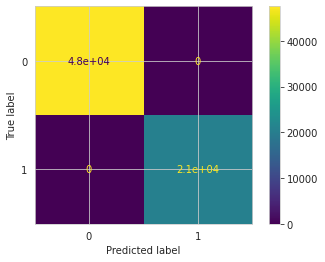

In [143]:
# Fit Gaussian Naive Bayes Classifier to our training data
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 

# Make prediction using our test data and model
y_pred = gnb.predict(X_test) 

# Comparing our prediction to response values
print("Gaussian Naive Bayes model accuracy(in %):", round(metrics.accuracy_score(y_test, y_pred)*100,2))
print("Gaussian Naive Bayes model F1-Score:", round(metrics.f1_score(y_test, y_pred)*100,2))

plot_confusion_matrix(gnb, X_test, y_test) 
plt.show()

## Random Forest

Random Forest Classifier model accuracy(in %): 99.84
Random Forest Classifier model F1-Score: 99.74


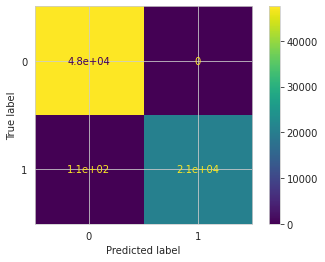

In [146]:
# Fit Random Forest Classifier to our Training Data
rfc = RandomForestClassifier(max_depth=5, random_state=2, n_estimators=750)
rfc.fit(X_train, y_train)

# make prediction using our test data and model
y_pred_rfc = rfc.predict(X_test)
y_prob_rfc = rfc.predict_proba(X_test)[:, 1]

# Comparing our prediciton to response values
print('Random Forest Classifier model accuracy(in %):', round(metrics.accuracy_score(y_test, y_pred_rfc)*100,2))
print("Random Forest Classifier model F1-Score:", round(metrics.f1_score(y_test, y_pred_rfc)*100,2))

plot_confusion_matrix(rfc, X_test, y_test) 
plt.show() 

The area under the ROC curve is: 1.0


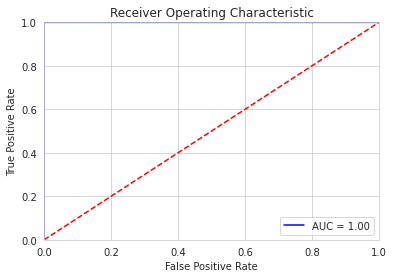

In [152]:
# Calculate ROC AUC for our best performing classifier, the Random Forest Classifier
roc_value = roc_auc_score(y_test, y_prob_rfc)
print('The area under the ROC curve is:', round(roc_value,2))

fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob_rfc)
roc_auc = metrics.auc(fpr, tpr)

# Plotting ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [153]:
# Calculate Log Loss
rfc_log_loss = log_loss(y_pred_rfc, y_prob_rfc, eps=1e-15)
print('Log Loss:', round(rfc_log_loss,2))

Log Loss: 0.14


# Feature Importance

In [157]:
# 
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. Feature 0 (0.405707)
2. Feature 2 (0.163418)
3. Feature 39 (0.097580)
4. Feature 7 (0.092653)
5. Feature 49 (0.056959)
6. Feature 17 (0.047835)
7. Feature 3 (0.025531)
8. Feature 1 (0.014472)
9. Feature 6 (0.010749)
10. Feature 38 (0.008634)
11. Feature 12 (0.006675)
12. Feature 5 (0.006561)
13. Feature 44 (0.006207)
14. Feature 4 (0.005139)
15. Feature 63 (0.005023)
16. Feature 31 (0.004336)
17. Feature 41 (0.004128)
18. Feature 66 (0.003848)
19. Feature 50 (0.003788)
20. Feature 9 (0.003172)
21. Feature 18 (0.003074)
22. Feature 34 (0.002765)
23. Feature 48 (0.002535)
24. Feature 16 (0.001906)
25. Feature 57 (0.001835)
26. Feature 45 (0.001665)
27. Feature 13 (0.001625)
28. Feature 25 (0.001249)
29. Feature 51 (0.001224)
30. Feature 40 (0.001076)
31. Feature 8 (0.000924)
32. Feature 19 (0.000838)
33. Feature 36 (0.000790)
34. Feature 23 (0.000747)
35. Feature 68 (0.000696)
36. Feature 55 (0.000596)
37. Feature 15 (0.000585)
38. Feature 47 (0.000497)
39. Feature 64

In [172]:
# Generating a dataframe for our feature importance

col_names = pd.Series([col for col in X_train.columns])

importance_df = pd.DataFrame(importances)
importance_df.rename(columns={0:'Importance'}, inplace=True)
importance_df.set_index(col_names,inplace=True)

imp_sorted = importance_df.sort_values(by='Importance', ascending=False)
imp_sorted = imp_sorted.round(4)
imp_sorted = imp_sorted[imp_sorted.Importance > 0]
imp_sorted.reset_index()

,index,Importance
0,activity_type_CustomerSupport,0.4057
1,activity_type_EmailOpen,0.1634
2,activity_pair_CustomerSupport_EmailOpen_exp,0.0976
3,activity_pair_CustomerSupport_EmailOpen_linear,0.0927
4,activity_pair_EmailOpen_EmailOpen_exp,0.0570
5,activity_pair_EmailOpen_EmailOpen_linear,0.0478
6,activity_type_FormSubmit,0.0255
7,activity_type_EmailClickthrough,0.0145
8,activity_pair_CustomerSupport_EmailClickthroug...,0.0107
9,activity_pair_CustomerSupport_EmailClickthroug...,0.0086


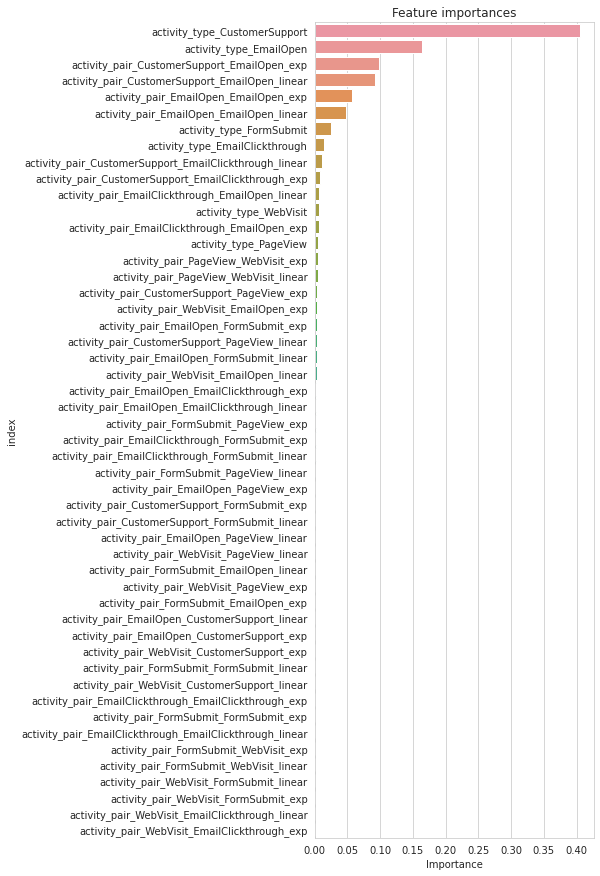

In [178]:
plt.figure(figsize=[5,15])
plt.title("Feature importances")
sns.barplot(data = imp_sorted.reset_index(), y = "index", x='Importance')
plt.show()

# Simplify Model

Things that can be inferred from feature importance:

1. Majority of `linear` and `exp` features are right next to each other. This means we are infering same information from them. This makes sense because they would be correlated. We can see that exp features are ranked above the linear ones. They are giving us more info. 

    Action: Remove linear features.
2. Activity_type and activity_pair both are important. With `customer support` being the most important.
We can filter out all non-relevant features and build a simplified model.


In [197]:
# Combine features and make final DF
df_final = df_dummy.merge(df_sequence_exp_final, on = 'user_id', how = 'left' )

df_final.drop(['session_id', 'activity_type_Purchase'], inplace = True, axis = 1)
print(df_final.shape)

(341568, 40)


In [198]:
# Remove columns not in to 10 of important features
cols_to_keep = [i for i in df_final.columns if i in list(imp_sorted.head(10).reset_index()['index'])] + ['user_id','purchase_flag']
df_final = df_final[cols_to_keep]

for c in df_final.columns:
  print(c)

activity_type_CustomerSupport
activity_type_EmailClickthrough
activity_type_EmailOpen
activity_type_FormSubmit
activity_pair_CustomerSupport_EmailClickthrough_exp
activity_pair_CustomerSupport_EmailOpen_exp
activity_pair_EmailOpen_EmailOpen_exp
user_id
purchase_flag


In [199]:
# Split train and test data
X_simp = df_final.drop(['purchase_flag', 'user_id'], axis=1)
y_simp = df_final['purchase_flag']
X_train, X_test, y_train, y_test = train_test_split(X_simp, y_simp,random_state=2, test_size=.2)

Random Forest Classifier model accuracy(in %): 100.0
Random Forest Classifier model F1-Score: 100.0


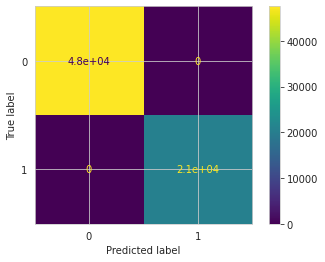

In [200]:
# Fit Random Forest Classifier to our Training Data
rfc_simp = RandomForestClassifier(max_depth=5, random_state=2, n_estimators=750)
rfc_simp.fit(X_train, y_train)

# make prediction using our test data and model
y_pred_rfc_simp = rfc_simp.predict(X_test)
y_prob_rfc_simp = rfc_simp.predict_proba(X_test)[:, 1]

# Comparing our prediciton to response values
print('Random Forest Classifier model accuracy(in %):', round(metrics.accuracy_score(y_test, y_pred_rfc_simp)*100,2))
print("Random Forest Classifier model F1-Score:", round(metrics.f1_score(y_test, y_pred_rfc_simp)*100,2))

plot_confusion_matrix(rfc_simp, X_test, y_test) 
plt.show() 

# Conslusion

We have two top performing models:
1. Gaussian NB. 

  Gaussian NB's are good at predicting activities like these. For instance, 1st production spam classifiers were NB. This is because of their ability to capture distributional data.

2. Simplified Random Forest.

  Random forests are king models. Features importance is straight forward with these.


Now lets import test.tsv and make real predictions.


In [227]:
df = pd.read_csv('./drive/MyDrive/Q3_2021_applications/6sense challange/test.tsv', delimiter='\t', names=['user_id', 'activity_date', 'activity_type'])
df['activity_date'] = pd.to_datetime(df['activity_date'])
df.activity_type.value_counts()

EmailOpen            550886
WebVisit              88595
PageView              87149
EmailClickthrough     42364
FormSubmit            28765
Name: activity_type, dtype: int64

No customer support.. hmm..

Simplified model is definately not going to work.. and applying the same pre-processing will not generate some columns that are expected. Need to account for those.

In [228]:
# Pre-processing:
# Feature 1: Type A: With session splits
df_dummy = pd.get_dummies(df, columns = ['activity_type'])
df_dummy = df_dummy.groupby(['user_id']).sum().reset_index()

df_dummy.head().T

# Feature 2: Sequence
def bigram(df):
  df['activity_pair'] = df['activity_type']+'_'+df['activity_type'].shift(-1).fillna('NONE')
  df['time_gap'] = (df['activity_date'].shift(-1) - df['activity_date']).dt.days
  return df

df_seq_dummy = df.groupby(['user_id']).apply(bigram).reset_index()
df_seq_dummy['time_gap_linear'] = 1/(df_seq_dummy['time_gap']+1)
df_seq_dummy['time_gap_decay'] = 1-(1/np.power(np.exp(df_seq_dummy['time_gap_linear']),3))
# df_seq_dummy.groupby(['user_id', 'activity_pair'])

                                                      
# df_seq_dummy = pd.get_dummies(df_seq_dummy, columns = ['activity_pair'])
df_seq_dummy = df_seq_dummy.groupby(['user_id', 'activity_pair']).sum().reset_index()
df_seq_dummy['activity_pair'] = 'activity_pair_' + df_seq_dummy['activity_pair']

# Build linear DF
df_sequence_linear = df_seq_dummy.pivot_table('time_gap_linear', ['user_id'], 'activity_pair')
df_sequence_linear.fillna(0, inplace = True)
df_sequence_linear = df_sequence_linear[df_sequence_linear.columns.drop(list(df_sequence_linear.filter(regex='NONE')))]
df_sequence_linear = df_sequence_linear[df_sequence_linear.columns.drop(list(df_sequence_linear.filter(regex='Purchase')))]

# Build exp DF
df_sequence_exp = df_seq_dummy.pivot_table('time_gap_decay', ['user_id'], 'activity_pair')
df_sequence_exp.fillna(0, inplace = True)
df_sequence_exp = df_sequence_exp[df_sequence_exp.columns.drop(list(df_sequence_exp.filter(regex='NONE')))]
df_sequence_exp = df_sequence_exp[df_sequence_exp.columns.drop(list(df_sequence_exp.filter(regex='Purchase')))]
df_sequence_exp.columns

# Combine features
df_sequence_linear_final = df_sequence_linear.rename(columns = { i: i+'_linear' for i in  df_sequence_linear.columns if i.startswith("activity_pair") } )
df_sequence_exp_final = df_sequence_exp.rename(columns = { i: i+'_exp' for i in  df_sequence_exp.columns if i.startswith("activity_pair") } )

df_final = df_dummy.merge(df_sequence_linear_final, on = 'user_id', how = 'left' )
df_final = df_final.merge(df_sequence_exp_final, on = 'user_id', how = 'left' )

In [230]:
# Insert missing cols
cols = ["user_id","purchase_flag","activity_type_CustomerSupport","activity_type_EmailClickthrough","activity_type_EmailOpen","activity_type_FormSubmit","activity_type_PageView","activity_type_WebVisit","activity_pair_CustomerSupport_EmailClickthrough_linear","activity_pair_CustomerSupport_EmailOpen_linear","activity_pair_CustomerSupport_FormSubmit_linear","activity_pair_CustomerSupport_PageView_linear","activity_pair_EmailClickthrough_CustomerSupport_linear","activity_pair_EmailClickthrough_EmailClickthrough_linear","activity_pair_EmailClickthrough_EmailOpen_linear","activity_pair_EmailClickthrough_FormSubmit_linear","activity_pair_EmailClickthrough_PageView_linear","activity_pair_EmailOpen_CustomerSupport_linear","activity_pair_EmailOpen_EmailClickthrough_linear","activity_pair_EmailOpen_EmailOpen_linear","activity_pair_EmailOpen_FormSubmit_linear","activity_pair_EmailOpen_PageView_linear","activity_pair_EmailOpen_WebVisit_linear","activity_pair_FormSubmit_CustomerSupport_linear","activity_pair_FormSubmit_EmailClickthrough_linear","activity_pair_FormSubmit_EmailOpen_linear","activity_pair_FormSubmit_FormSubmit_linear","activity_pair_FormSubmit_PageView_linear","activity_pair_FormSubmit_WebVisit_linear","activity_pair_PageView_EmailClickthrough_linear","activity_pair_PageView_EmailOpen_linear","activity_pair_PageView_FormSubmit_linear","activity_pair_PageView_PageView_linear","activity_pair_PageView_WebVisit_linear","activity_pair_WebVisit_CustomerSupport_linear","activity_pair_WebVisit_EmailClickthrough_linear","activity_pair_WebVisit_EmailOpen_linear","activity_pair_WebVisit_FormSubmit_linear","activity_pair_WebVisit_PageView_linear","activity_pair_WebVisit_WebVisit_linear","activity_pair_CustomerSupport_EmailClickthrough_exp","activity_pair_CustomerSupport_EmailOpen_exp","activity_pair_CustomerSupport_FormSubmit_exp","activity_pair_CustomerSupport_PageView_exp","activity_pair_EmailClickthrough_CustomerSupport_exp","activity_pair_EmailClickthrough_EmailClickthrough_exp","activity_pair_EmailClickthrough_EmailOpen_exp","activity_pair_EmailClickthrough_FormSubmit_exp","activity_pair_EmailClickthrough_PageView_exp","activity_pair_EmailOpen_CustomerSupport_exp","activity_pair_EmailOpen_EmailClickthrough_exp","activity_pair_EmailOpen_EmailOpen_exp","activity_pair_EmailOpen_FormSubmit_exp","activity_pair_EmailOpen_PageView_exp","activity_pair_EmailOpen_WebVisit_exp","activity_pair_FormSubmit_CustomerSupport_exp","activity_pair_FormSubmit_EmailClickthrough_exp","activity_pair_FormSubmit_EmailOpen_exp","activity_pair_FormSubmit_FormSubmit_exp","activity_pair_FormSubmit_PageView_exp","activity_pair_FormSubmit_WebVisit_exp","activity_pair_PageView_EmailClickthrough_exp","activity_pair_PageView_EmailOpen_exp","activity_pair_PageView_FormSubmit_exp","activity_pair_PageView_PageView_exp","activity_pair_PageView_WebVisit_exp","activity_pair_WebVisit_CustomerSupport_exp","activity_pair_WebVisit_EmailClickthrough_exp","activity_pair_WebVisit_EmailOpen_exp","activity_pair_WebVisit_FormSubmit_exp","activity_pair_WebVisit_PageView_exp","activity_pair_WebVisit_WebVisit_exp"]
df_final = df_final.reindex(df_final.columns.union(cols, sort=False), axis=1, fill_value=0)
df_final = df_final[cols]
# Display
print(df_final.shape)
for c in df_final.columns:
  print(c)

(132810, 72)
user_id
purchase_flag
activity_type_CustomerSupport
activity_type_EmailClickthrough
activity_type_EmailOpen
activity_type_FormSubmit
activity_type_PageView
activity_type_WebVisit
activity_pair_CustomerSupport_EmailClickthrough_linear
activity_pair_CustomerSupport_EmailOpen_linear
activity_pair_CustomerSupport_FormSubmit_linear
activity_pair_CustomerSupport_PageView_linear
activity_pair_EmailClickthrough_CustomerSupport_linear
activity_pair_EmailClickthrough_EmailClickthrough_linear
activity_pair_EmailClickthrough_EmailOpen_linear
activity_pair_EmailClickthrough_FormSubmit_linear
activity_pair_EmailClickthrough_PageView_linear
activity_pair_EmailOpen_CustomerSupport_linear
activity_pair_EmailOpen_EmailClickthrough_linear
activity_pair_EmailOpen_EmailOpen_linear
activity_pair_EmailOpen_FormSubmit_linear
activity_pair_EmailOpen_PageView_linear
activity_pair_EmailOpen_WebVisit_linear
activity_pair_FormSubmit_CustomerSupport_linear
activity_pair_FormSubmit_EmailClickthrough_lin

## Run RF

In [248]:
# Data prep
X = df_final.drop(['purchase_flag'], axis=1)
X = X.set_index('user_id')


# Predictions
y_prob_rfc = rfc.predict_proba(X)

X['prob_purchase'] = y_prob_rfc[:,1]

,activity_type_CustomerSupport,activity_type_EmailClickthrough,activity_type_EmailOpen,activity_type_FormSubmit,activity_type_PageView,activity_type_WebVisit,activity_pair_CustomerSupport_EmailClickthrough_linear,activity_pair_CustomerSupport_EmailOpen_linear,activity_pair_CustomerSupport_FormSubmit_linear,activity_pair_CustomerSupport_PageView_linear,activity_pair_EmailClickthrough_CustomerSupport_linear,activity_pair_EmailClickthrough_EmailClickthrough_linear,activity_pair_EmailClickthrough_EmailOpen_linear,activity_pair_EmailClickthrough_FormSubmit_linear,activity_pair_EmailClickthrough_PageView_linear,activity_pair_EmailOpen_CustomerSupport_linear,activity_pair_EmailOpen_EmailClickthrough_linear,activity_pair_EmailOpen_EmailOpen_linear,activity_pair_EmailOpen_FormSubmit_linear,activity_pair_EmailOpen_PageView_linear,activity_pair_EmailOpen_WebVisit_linear,activity_pair_FormSubmit_CustomerSupport_linear,activity_pair_FormSubmit_EmailClickthrough_linear,activity_pair_FormSubmit_EmailOpen_linear,activity_pair_FormSubmit_FormSubmit_linear,activity_pair_FormSubmit_PageView_linear,activity_pair_FormSubmit_WebVisit_linear,activity_pair_PageView_EmailClickthrough_linear,activity_pair_PageView_EmailOpen_linear,activity_pair_PageView_FormSubmit_linear,activity_pair_PageView_PageView_linear,activity_pair_PageView_WebVisit_linear,activity_pair_WebVisit_CustomerSupport_linear,activity_pair_WebVisit_EmailClickthrough_linear,activity_pair_WebVisit_EmailOpen_linear,activity_pair_WebVisit_FormSubmit_linear,activity_pair_WebVisit_PageView_linear,activity_pair_WebVisit_WebVisit_linear,activity_pair_CustomerSupport_EmailClickthrough_exp,activity_pair_CustomerSupport_EmailOpen_exp,activity_pair_CustomerSupport_FormSubmit_exp,activity_pair_CustomerSupport_PageView_exp,activity_pair_EmailClickthrough_CustomerSupport_exp,activity_pair_EmailClickthrough_EmailClickthrough_exp,activity_pair_EmailClickthrough_EmailOpen_exp,activity_pair_EmailClickthrough_FormSubmit_exp,activity_pair_EmailClickthrough_PageView_exp,activity_pair_EmailOpen_CustomerSupport_exp,activity_pair_EmailOpen_EmailClickthrough_exp,activity_pair_EmailOpen_EmailOpen_exp,activity_pair_EmailOpen_FormSubmit_exp,activity_pair_EmailOpen_PageView_exp,activity_pair_EmailOpen_WebVisit_exp,activity_pair_FormSubmit_CustomerSupport_exp,activity_pair_FormSubmit_EmailClickthrough_exp,activity_pair_FormSubmit_EmailOpen_exp,activity_pair_FormSubmit_FormSubmit_exp,activity_pair_FormSubmit_PageView_exp,activity_pair_FormSubmit_WebVisit_exp,activity_pair_PageView_EmailClickthrough_exp,activity_pair_PageView_EmailOpen_exp,activity_pair_PageView_FormSubmit_exp,activity_pair_PageView_PageView_exp,activity_pair_PageView_WebVisit_exp,activity_pair_WebVisit_CustomerSupport_exp,activity_pair_WebVisit_EmailClickthrough_exp,activity_pair_WebVisit_EmailOpen_exp,activity_pair_WebVisit_FormSubmit_exp,activity_pair_WebVisit_PageView_exp,activity_pair_WebVisit_WebVisit_exp,prob_purchase
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000ecf58c94668,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.278967,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0.0,0.729987,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0.057480
000132f21724ee2,0,1,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0,0,0,0,0,0.0,0.950213,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0.087730
0001b315b991cf0,0,0,3,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.518182,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0.0,0.829954,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0,0.0,0.000000,0.0,0.0,0.0,0.057483
000269150971d08,0,0,4,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.413271,0.0,0.0,0.

In [251]:
top_1k_purchasers_list = X.sort_values('prob_purchase', ascending=False).head(1000).reset_index()['user_id']

top_1k_purchasers_list.to_csv('./drive/MyDrive/Q3_2021_applications/6sense challange/result.csv',index=False)